In [2]:
from random import randint
from Crypto.Hash import SHA256
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.PublicKey import RSA
from Crypto.Random import get_random_bytes
from Crypto.Util.number import long_to_bytes, bytes_to_long, inverse
from Crypto.Cipher import PKCS1_v1_5
from Crypto.Cipher import PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto import Random
import time

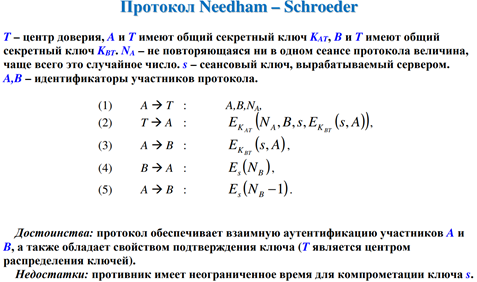

In [54]:
KEY_AT = get_random_bytes(16)
KEY_BT = get_random_bytes(16)

class Certification_Authority:
    def __init__(self, KEY_AT, KEY_BT):
        self._E_A = KEY_AT
        self._E_B = KEY_BT
        print('[Trent]: сервером сгенерирован сеансовый ключ s')
        self._s = get_random_bytes(16)
        self.Na = None
        self.A = None
        self.B = None
        print('[Trent]: инициализирован Трент с долговременными ключами для общения с Alice и Bob')
        
    def get_Alice_mess(self,mess):
        print('\n[Trent]: получено сообщение от Alice: ', mess)
        self.Na = mess[0]
        self.A = mess[1]
        self.B = mess[2]
        mess_for_Alice = self.encrypt_answer_for_Alice()
        return mess_for_Alice
        
    def encrypt_answer_for_Alice(self):
        """
        формирование ответа для Alice:  E_kAT(Na,B,s,E_kBT(s,Na))
        """
        E_kAT = AES.new(self._E_A, AES.MODE_ECB)
        E_kBT = AES.new(self._E_B, AES.MODE_ECB)
        mes = self.Na + self.B + self._s + E_kBT.encrypt(self._s + self.Na)
        print('\n[Trent]: E_kAT(Na,B,s,E_kBT(s,Na)) будет отправлено Алисе:', mes)
        return E_kAT.encrypt(mes)
    

class Alice: 
    def __init__(self, KEY_AT):
        self._key_AT = KEY_AT
        self.Na = get_random_bytes(16)
        print('[Alice]: сгенерировано случайное число Na: ', self.Na)
        
    def send_Alice_mess_to_T_and_get_response(self,CA,A,B):
        response = CA.get_Alice_mess((self.Na,A,B))
        E_kAT = AES.new(self._key_AT, AES.MODE_ECB)
        m = E_kAT.decrypt(response)
        print('\n[Alice]: \n-- получено от Trent:',response,'\n-- расшифровано:', m)
        # Проверим, что в зашифрованном сообщении есть идентификатор Alice
        if m.find(self.Na) != -1:
            print("\n[ALice]: Проверка наличия Na Alice в сообщении Trent пройдена")
        s = m[-48:-32]
        print("\n[Alice]: s:", s)
        CT_EkBT = m[-32:]
        return  CT_EkBT, s       
        
    def send_Alice_mess_to_Bob(self,s,mes):
        E_kBT = AES.new(s, AES.MODE_ECB)
        Nb = E_kBT.decrypt(mes)
        print('[Alice]: от Bob получено Nb: ',Nb)
        Nb_1 = long_to_bytes(bytes_to_long(Nb) - 1)
        print('[Alice]: вычисляю Nb-1: ',Nb_1)
        E_kBT = AES.new(s, AES.MODE_ECB)
        mes = E_kBT.encrypt(Nb_1)
        print('[Alice]:зашифровала:',mes)
        return(mes)
    
class Bob:
    def __init__(self, KEY_BT):
        self._key_BT = KEY_BT
        self.Nb = get_random_bytes(16)
        print('[Bob]: сгенерировано случайное число Nb: ', self.Nb)
        
    
    def get_mess_from_Alice_and_send_Nb(self,s):
        cipher_k = AES.new(s, AES.MODE_ECB)
        mes = cipher_k.encrypt(self.Nb)
        print("[Bob]: отправка Alice Nb", self.Nb )
        return(mes)
    

    def decrypt_mes(self, CT_EkBT):
        print("[Bob]: зашифрованный ключом Bob (s,A):", CT_EkBT)
        EkBT = AES.new(self._key_BT, AES.MODE_ECB)
        mes = EkBT.decrypt(CT_EkBT)
        s = mes[:16]
        print("\n[Bob]: s:", s)
        return s

    def check_k_alice(self, s, mes):
        cipher_k = AES.new(s, AES.MODE_ECB)
        plain = cipher_k.decrypt(mes)
        Nb_1=  long_to_bytes(bytes_to_long(self.Nb)-1)
        print(Nb_1)
        print("[Bob]:расшифровал на ключе s:", plain)
        if Nb_1 == plain:
            print("[Bob]: Alice и Bob владеют общим секретным ключом")
        return 



In [55]:
CA = Certification_Authority(KEY_AT, KEY_BT)

# идентификаторы Aлисы и Боба
A = b'0000000000000000'
B = b'0000000000000001'
Alice_ = Alice(KEY_AT)
Bob_ = Bob(KEY_BT)

CT_EkBT, s = Alice_.send_Alice_mess_to_T_and_get_response(CA,A,B) # mess_1 = A,B,Na

s = Bob_.decrypt_mes(CT_EkBT) # mess_2 = CT_EkBT = EkAT = (Na,B,S,EkBT(s,A))

mess_3 = Bob_.get_mess_from_Alice_and_send_Nb(s) # mess_3 = EkBT(s,A)
mess_4 = Alice_.send_Alice_mess_to_Bob(s, mess_3) # mess = Es(Nb)
Bob_.check_k_alice(s, mess_4) # mess = Es(Nb-1)

[Trent]: сервером сгенерирован сеансовый ключ s
[Trent]: инициализирован Трент с долговременными ключами для общения с Alice и Bob
[Alice]: сгенерировано случайное число Na:  b'\xbb\xe2 \xa4\xb4\xbe\xf7\xe0\xd7\x18\xcb\x06\xc7\x1b"\x11'
[Bob]: сгенерировано случайное число Nb:  b"J\x83\xdf\xc4\x87T\xb1\xcc'\xaaVH0\xfe\xfaQ"

[Trent]: получено сообщение от Alice:  (b'\xbb\xe2 \xa4\xb4\xbe\xf7\xe0\xd7\x18\xcb\x06\xc7\x1b"\x11', b'0000000000000000', b'0000000000000001')

[Trent]: E_kAT(Na,B,s,E_kBT(s,Na)) будет отправлено Алисе: b'\xbb\xe2 \xa4\xb4\xbe\xf7\xe0\xd7\x18\xcb\x06\xc7\x1b"\x110000000000000001<\x88H.\x10Ze\xfd<W\x9e\x12\xac-\xefKv\x1e\xe4\xddJ\xbfz\xcb(\xd6\xe98\xea\x1bl\xa4\xa9\xbb]\xdf\xb7}\xc0Q\x96\t\xa7\xe65\xbdn\x98'

[Alice]: 
-- получено от Trent: b'\xa5Sh\x05\xb4Y\xc7\xe4Mf\x8a\xe1z\xe3y\x0f\x89\x18\x0f\xa3\xaf\xea\xd5^\xea\xe2py\xa4\xae\xe9\xd2\xfa\xa9&\xfca\xcf\x16\xdd5\xe7\xc4\x1e\xe5\x8e\xba>\xa2\x9b\x93k\x1b\xf6L%\xc5\xc2K\x92\xe40i\xf7\xedl\xab7\xf8\x00,\xe95\xe6w

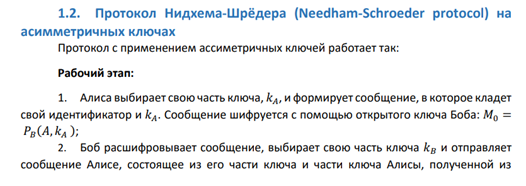
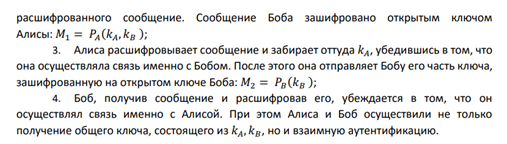

In [179]:
SENTINEL = Random.new().read(15+16) 

class Alice_:
    def __init__(self):
        self._A = b'11111111111110'
        self._k_A = get_random_bytes(16)
        # первоначально неизвестно
        self._k_B = None
        # rsa
        self._sk_A = RSA.generate(2048)
        self.pk_A = self._sk_A.publickey()
        
        print("[Alice]: ka - ", self._k_A)
        print("[Alice]: kb - ", self._k_B)
        
    def send_mess_1(self,Pb):
        RSA_ = PKCS1_v1_5.new(Pb)
        plaintext = long_to_bytes(self._A)+(self._k_A)
        print("\n[Alice]: сформировано 1 сообщение A+kA: ", plaintext)
        print("[Alice]: зашифровано на открытом ключе Bob и отправлено")
        ciphertext = RSA_.encrypt(plaintext)
        return ciphertext
    
    def accept_mess_2_and_send_mess_3(self,M1,Pb):
        RSA_ = PKCS1_v1_5.new(self._sk_A)
        ka_kb = RSA_.decrypt(M1, SENTINEL)
        print("\n[Alice]: получено сообщение k_A+k_B: ", ka_kb)
        ka = ka_kb[:16]
        self._k_B = ka_kb[16:]
        if ka == self._k_A:
            print("[Alice]: Bob аутентифицирован, т.к. получен ka: ", ka)
        else:
            print("[Alice]: Bob не аутентифицирован")
            return None
    
        RSA_ = PKCS1_v1_5.new(Pb)
        print("[Alice]: отправляется сообщение:",self._k_B)
        ciphertext = RSA_.encrypt(self._k_B)
        return ciphertext

class Bob_:
    def __init__(self):
        self._B = b'11111111111111'
        # часть ключа от B
        self._k_B = get_random_bytes(16)
        # первоначально неизвестно
        self._k_A = None
        # rsa
        self._sk_B = RSA.generate(2048)
        self.pk_B = self._sk_B.publickey()
        print("[Bob]: ka - ", self._k_A)
        print("[Bob]: kb - ", self._k_B)
        
    def accept_mess_1_and_send_mess_2(self,M0,Pa):
        RSA_ = PKCS1_v1_5.new(self._sk_B)
        mes = RSA_.decrypt(M0,SENTINEL)
        self._k_A = mes[-16:]
        print("\n[Bob]: получено 1 сообщение (A,k_A):", mes)
        print("[Bob]: k_A:", self._k_A)
        RSA_ = PKCS1_v1_5.new(Pa)
        ciphertext = RSA_.encrypt(self._k_A + self._k_B)
        print("[Bob]: отправка Alice ключа k_A + k_B:", self._k_A + self._k_B)
        print("[Bob]: зашифровано на открытом ключе Alice и отправлено")
        return ciphertext
    
    def accept_mess_3(self,M2):
        RSA_ = PKCS1_v1_5.new(self._sk_B)
        kb = RSA_.decrypt(M2,SENTINEL)
        if kb == self._k_B:
            print("\n[Bob]:  Alice аутентифицирована, т.к. получен kb:", kb)
            print("[Bob]: взаимная аутентифкация пройдена")
            print("[Bob]: общий ключ: ka,kb ", self._k_A + self._k_B)
        else:
            self._k_A=None
            print("Error")
            raise
        return

In [180]:
Alice = Alice_()
Bob = Bob_()

Pa = Alice.pk_A
Pb = Bob.pk_B
mess_1 = Alice.send_mess_1(Pb) # mess = Pb(A,k_A)
mess_2 = Bob.accept_mess_1_and_send_mess_2(mess_1,Pa) # mess = Pa(k_A + k_B)
mess_3 = Alice.accept_mess_2_and_send_mess_3(mess_2,Pb) # mess = Pb(k_B) для вз.аут. 
Bob.accept_mess_3(mess_3) # check k_B

print("\nУ каждого участника есть ключ ka+kb:")
print("[Alice]: ka ", Alice._k_A)
print("[Alice]: kb ", Alice._k_B)
print("  [Bob]: ka ", Bob._k_A)
print("  [Bob]: kb ", Bob._k_B)

[Alice]: ka -  b'\x14\xb6..\x95\xc2\x9f\xe8H\xd8^\xd6 \xbeb\xbb'
[Alice]: kb -  None
[Bob]: ka -  None
[Bob]: kb -  b'8\x05y\xe0\x87\x03\xe5\xa9A\xdd\xdd\x83\x93\x80r\r'

[Alice]: сформировано 1 сообщение A+kA:  b'\n\x1b\x01\xd4\xb1\xc6\x14\xb6..\x95\xc2\x9f\xe8H\xd8^\xd6 \xbeb\xbb'
[Alice]: зашифровано на открытом ключе Bob и отправлено

[Bob]: получено 1 сообщение (A,k_A): b'\n\x1b\x01\xd4\xb1\xc6\x14\xb6..\x95\xc2\x9f\xe8H\xd8^\xd6 \xbeb\xbb'
[Bob]: k_A: b'\x14\xb6..\x95\xc2\x9f\xe8H\xd8^\xd6 \xbeb\xbb'
[Bob]: отправка Alice ключа k_A + k_B: b'\x14\xb6..\x95\xc2\x9f\xe8H\xd8^\xd6 \xbeb\xbb8\x05y\xe0\x87\x03\xe5\xa9A\xdd\xdd\x83\x93\x80r\r'
[Bob]: зашифровано на открытом ключе Alice и отправлено

[Alice]: получено сообщение k_A+k_B:  b'\x14\xb6..\x95\xc2\x9f\xe8H\xd8^\xd6 \xbeb\xbb8\x05y\xe0\x87\x03\xe5\xa9A\xdd\xdd\x83\x93\x80r\r'
[Alice]: Bob аутентифицирован, т.к. получен ka:  b'\x14\xb6..\x95\xc2\x9f\xe8H\xd8^\xd6 \xbeb\xbb'
[Alice]: отправляется сообщение: b'8\x05y\xe0\x87\x03\x

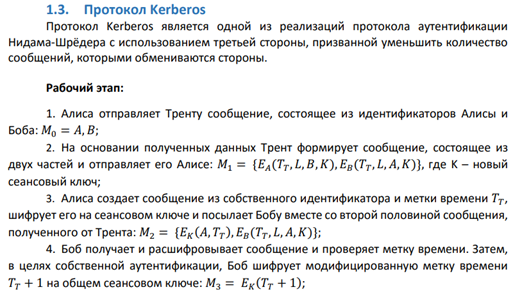

In [107]:
KEY_AT = get_random_bytes(AES.block_size)
KEY_BT = get_random_bytes(AES.block_size)
A = b'1111111111111110'
B = b'1111111111111111'

class Certification_Authority:
    def __init__(self, KEY_AT, KEY_BT):
        self._k_AT = KEY_AT
        self._k_BT = KEY_BT
        self._K = get_random_bytes(AES.block_size)
        print("[Trent]: сгенерирован s:", self._K)
        
    def accept_mess_1_from_Alice_and_send_response(self, mess_1):
        A, B = mess_1[0], mess_1[1]
        print("\n[Trent]: получено 2 сообщение А+B:", A, B)
        TT = pad(bytes(str(int(time.time())), 'utf-8'), AES.block_size)
        print("[Trent]: извлечена метка времени:", TT)
        L = get_random_bytes(16)
        E_kAT = AES.new(self._k_AT, AES.MODE_ECB)
        E_kBT = AES.new(self._k_BT, AES.MODE_ECB)
        part_1 = E_kAT.encrypt(TT + L + B + self._K)
        part_2 = E_kBT.encrypt(TT + L + A + self._K)
        print("[Trent]: Alice отправлено mess_2 = E_kAT(TT + L + B + K) + E_kBT(TT + L + A + K): ",part_1,part_2)
        return part_1,part_2 # mess_2 = E_kAT(TT + L + B + K) + E_kBT(TT + L + A + K)
    
class Alice_:
    def __init__(self, KEY_AT, A):
        self._k_AT = KEY_AT
        self.A = A
        self._K = None
        self._TT = None
        print("[Alice]: сеансовый ключ неизвестен:", self._K)    

    def accept_mess_2_from_Trent_send_to_Bob(self, mess_2):
        print("\n[Alice]: принято сообщение mess_2")
        E_kAT = AES.new(self._k_AT, AES.MODE_ECB)
        m = E_kAT.decrypt(mess_2[0])
        #extract TT, K
        self._TT = unpad(m[:AES.block_size], AES.block_size)
        self._K = m[-AES.block_size:]
        print("[Alice]: извлечен K и TT: ",self._TT)
        
        E_k = AES.new(self._K, AES.MODE_ECB)
        part_1 = E_k.encrypt(self.A + pad(self._TT,AES.block_size))
        print("[Alice]: Bob отправлено mess_3 = E_K(A,TT) + E_kBT(TT + L + A + K): ",part_1,mess_2[1])
        return  part_1,mess_2[1] # mess_3 = E_K(A,TT) + E_kBT(TT + L + A + K)
    
    def accept_mess_4_from_Bob_and_check(self,M3):
        E_k = AES.new(self._K, AES.MODE_ECB)
        TT = unpad(E_k.decrypt(M3), AES.block_size)
        TT_1 = long_to_bytes(bytes_to_long(self._TT)+1)
        if TT_1 == TT:
            print("[Alice]: Bob авторизован, так как проверена метка времени, которую он зашифровал сеансовым ключом")
            print("\n[Alice]: Алиса и Боб владеют общим секретным ключом K: ",
                  self._K)
            return TT_1 == TT

class Bob_:
    def __init__(self, KEY_BT, B):
        self._k_BT = KEY_BT
        self.B = B
        self._K = None
        self._TT = None
        
    def accept_mess_3_from_Alice_send_response(self, mess_3):
        print("\n[Bob]: принято сообщение mess_3")
        E_kAT = AES.new(self._k_BT, AES.MODE_ECB)
        plaintext = E_kAT.decrypt(mess_3[1])
        # extract K, TT
        self._K = plaintext[-AES.block_size:]
        self._TT = unpad(plaintext[:AES.block_size], AES.block_size)
        print("[Bob]: извлечен K и TT: ",self._TT)
        
        E_k = AES.new(self._K, AES.MODE_ECB)
        plaintext = E_k.decrypt(mess_3[0])
        if self._TT == (unpad(plaintext[-AES.block_size:],AES.block_size)):
            print("[Bob]: Alice авторизована, так как проверена метка времени, которую она зашифровала")
        else:
            print("[Bob]: Error, Alice не авторизована")
            raise
        TT_1 = pad(long_to_bytes(bytes_to_long(self._TT) + 1),AES.block_size)
        response = E_k.encrypt(TT_1)
        print("[Bob]: Alice отправлено mess_4 = E_k(TT+1): ",response)
        return response # mess_4 = E_k(TT+1)

In [108]:
CA = Certification_Authority(KEY_AT, KEY_BT)
Alice = Alice_(KEY_AT, A)
Bob = Bob_(KEY_BT, B)

mess_1 = (A,B)
mess_2 = CA.accept_mess_1_from_Alice_and_send_response(mess_1) # mess_2 = E_kAT(TT + L + B + K) + E_kBT(TT + L + A + K)
mess_3 = Alice.accept_mess_2_from_Trent_send_to_Bob(mess_2) # mess_3 = E_K(A,TT) + E_kBT(TT + L + A + K)
mess_4 = Bob.accept_mess_3_from_Alice_send_response(mess_3) # mess_4 = E_k(TT+1)
Alice.accept_mess_4_from_Bob_and_check(mess_4)

[Trent]: сгенерирован s: b'J\xe3z\xcf;]\xacf\xc2\xe7j\xd5\xb2\x87\xb87'
[Alice]: сеансовый ключ неизвестен: None

[Trent]: получено 2 сообщение А+B: b'1111111111111110' b'1111111111111111'
[Trent]: извлечена метка времени: b'1619739222\x06\x06\x06\x06\x06\x06'
[Trent]: Alice отправлено mess_2 = E_kAT(TT + L + B + K) + E_kBT(TT + L + A + K):  b'\x18\x11\x9a~f\xa5x\xf3\xd5\x9fRc\rvR\xf5?\xeaV\xdad9?[\x9av\xa66\x12\x85\n\xe3\x9d\x97\xdc\xe6\xa7=0\xd3\x10s\xa9\xed\xe65g\xf5\x86\x9b\xc6qY\x1e\xc8w\xa1\xc3m\x93\x07\x0c2\x03' b'qDY\xd5\x8a\xda\x96\xb1s\xa9r\x18\x84+\x99M\xa9\x98?\xd1\xa7\x0f`0\xd4\x84n\x1f\t\xdf[V\x15\xbe"\xb5\\%\xfd\x08\x99\x84\x89?j\x11|g_\xcf\xfb6C\xf6W\t\xd69\xc6\xd1 n\x17\xa7'

[Alice]: принято сообщение mess_2
[Alice]: извлечен K и TT:  b'1619739222'
[Alice]: Bob отправлено mess_3 = E_K(A,TT) + E_kBT(TT + L + A + K):  b"|\xee!\x8a\\H\x9f\xada\xf4\xe5\x1a]\xb5\xaf-\x07g6%/\x1d\xd0K\xc1'?\xd5\xbc\xb2!w" b'qDY\xd5\x8a\xda\x96\xb1s\xa9r\x18\x84+\x99M\xa9\x98?\xd1\xa7\x0f`0\

True

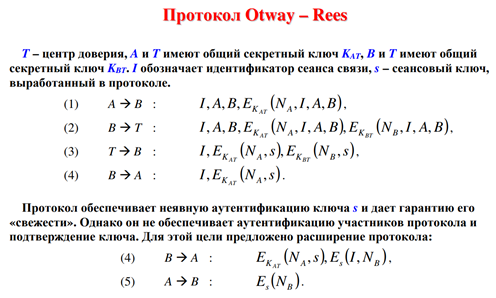

In [175]:
KEY_AT = get_random_bytes(AES.block_size)
KEY_BT = get_random_bytes(AES.block_size)

class Certification_Authority:
    def __init__(self, KEY_AT, KEY_BT):
        self._A_sk = KEY_AT
        self._B_sk = KEY_BT
        self._s = get_random_bytes(AES.block_size)
        print("[Trent]: сгенерирован s:", self._s)
        
    def accept_mess_2_from_B_and_send_3_to_B(self, mess_2):
        print("\n[Trent]:")
        E_kAT = AES.new(self._A_sk, AES.MODE_ECB)
        E_kBT = AES.new(self._B_sk, AES.MODE_ECB)
        
        I = mess_2[0][:AES.block_size]
        Na = (E_kAT.decrypt(mess_2[1]))[:AES.block_size]
        Nb = (E_kBT.decrypt(mess_2[2]))[:AES.block_size]
        print("\n-получен I:",I)
        print("\n-получен Na:",Na)
        print("\n-получен Nb:",Nb)
        part_1 = E_kAT.encrypt(Na + self._s)
        part_2 = E_kBT.encrypt(Nb + self._s)
        output = (I,part_1,part_2)
        print("\n-сформировано сообщение 3 для Bob:",output)
        return output

class Alice_:
    def __init__(self, KEY_AT):
        self._A_sk = KEY_AT
        self.A = b'1111111111111110'
        self._Na = get_random_bytes(AES.block_size)
        self._I = get_random_bytes(AES.block_size)
        self._s = None
        print("[Alice]: \n- идентификатор сеанса связи:", self._I,
              "\n- сеансовый ключ неизвестен:", self._s)
        
    def send_mess_1_to_Bob(self):
        part_1 = self._I + self.A + B
        E_kAT = AES.new(self._A_sk, AES.MODE_ECB)
        part_2 = E_kAT.encrypt(self._Na + part_1)
        print("[Alice]: сформировано 1 сообщение для Bob:", part_1,part_2)
        return (part_1,part_2)    

    def accept_mess_4_from_Bob(self,mess_4):
        E_kAT = AES.new(self._A_sk, AES.MODE_ECB)
        print("\n[Alice]:\n- от Bob получено сообщение:", mess_4)
        m = E_kAT.decrypt(mess_4[1])
        if self._Na == m[:16]:
            print("- Trent аутентифицирован, т.к. полученое и расшифрованное сообщение содержит Na:", m)
        else:
            print("Error")
            raise
        self._s = m[16:]
        print("\nАлиса и Боб владеют общим секретным ключом s:", self._s)
        return 
    
class Bob_:
    def __init__(self, KEY_BT):
        self._B_sk = KEY_BT
        self._Nb = get_random_bytes(AES.block_size)
        self.B = b'1111111111111111'
        self._s = None
    
    def accept_mess_1_from_Alice_send_mess_2_to_Trent(self, mess_1):
        cipher_b = AES.new(self._B_sk, AES.MODE_ECB)
        m2 = cipher_b.encrypt(self._Nb + mess_1[0])
        output = (mess_1[0],mess_1[1],m2) # I + A + B + E_kAT(Na + I + A + B) + E_kBT(Nb + I + A + B)
        print("\n[Bob]: сформировано сообщение 2 для Trent:", output)
        return output
    
    def accept_mess_3_from_Trent_send_mess_4_to_Alice(self,mess_3):
        E_kBT = AES.new(self._B_sk, AES.MODE_ECB)
        m = E_kBT.decrypt(mess_3[2])
        print("\n[Bob]: \n- получено зашифрованное сообщение 3 от Trent")
        if self._Nb == m[:AES.block_size]:
            print("- Trent аутентифицирован, т.к. полученое и расшифрованное сообщение содержит Nb:", m)
        else:
            print("Error")
        self._s = m[AES.block_size:]
        # Bob берет свою часть, остальное Alice
        print("[Bob]: расшифрована вторая часть сообщения, Alice пересылается первая часть:", mess_3[0],mess_3[1])
        return mess_3[0],mess_3[1]
    

In [177]:
CA = Certification_Authority(KEY_AT, KEY_BT)
Alice = Alice_(KEY_AT)
Bob = Bob_(KEY_BT)
mess_1 = Alice.send_mess_1_to_Bob() # send I + A + B + E_kAT(Na + I + A + B)
mess_2 = Bob.accept_mess_1_from_Alice_send_mess_2_to_Trent(mess_1) # I + A + B + E_kAT(Na + I + A + B) + E_kBT(Nb + I + A + B)
mess_3 = CA.accept_mess_2_from_B_and_send_3_to_B(mess_2) # I + E_kAT(Na + s) + E_kBT(Nb + s)
mess_4 = Bob.accept_mess_3_from_Trent_send_mess_4_to_Alice(mess_3) # I + E_kAT(Na + s)
Alice.accept_mess_4_from_Bob(mess_4) # result

[Trent]: сгенерирован s: b'(\x03\xfc\xa4\xc6\xcc\xbeDd\xb3\xec\x1b\xb7\xfc\x85\xbd'
[Alice]: 
- идентификатор сеанса связи: b'\x0e\x89\x9d\xbb\xf0w\xb7\xd1\\\x97V\xc4]\xb3\x8dY' 
- сеансовый ключ неизвестен: None
[Alice]: сформировано 1 сообщение для Bob: b'\x0e\x89\x9d\xbb\xf0w\xb7\xd1\\\x97V\xc4]\xb3\x8dY11111111111111100000000000000001' b"e\xd2d\xfah\x08\xd8\x0eD\x86\xedF\xe4\x84\xa9\x95\x18\x1eV\xcd&\x98\xa7\xce\x95/uh`\x19`4\x1cG-\xd6\x91\xc5\x19/O?wFH\x83\xe3\x96'\xd3\xb0+\xef\x8f\xed\xc2!\xd0\xbeH\x1a\x8c\xd6\xb0"

[Bob]: сформировано сообщение 2 для Trent: (b'\x0e\x89\x9d\xbb\xf0w\xb7\xd1\\\x97V\xc4]\xb3\x8dY11111111111111100000000000000001', b"e\xd2d\xfah\x08\xd8\x0eD\x86\xedF\xe4\x84\xa9\x95\x18\x1eV\xcd&\x98\xa7\xce\x95/uh`\x19`4\x1cG-\xd6\x91\xc5\x19/O?wFH\x83\xe3\x96'\xd3\xb0+\xef\x8f\xed\xc2!\xd0\xbeH\x1a\x8c\xd6\xb0", b"\xca\x16\xee\x077\x88\x10^\x07\x18G\xd7'\xc0x\x1f\xeae(\xad\x05\x97\xc4\xd0\xeaC~v@\xbe\\\xaf\xb0\xc6\x0e\x8eA\xf77\xc2\x9b9S1R\xb6\x0e'\xe7\xa1`\xb0:l\x